In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('ap.csv', index_col='Month', parse_dates=True)
df.rename(columns={'#Passengers': 'Passengers'}, inplace=True)
print(df)

            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1960-08-01         606
1960-09-01         508
1960-10-01         461
1960-11-01         390
1960-12-01         432

[144 rows x 1 columns]


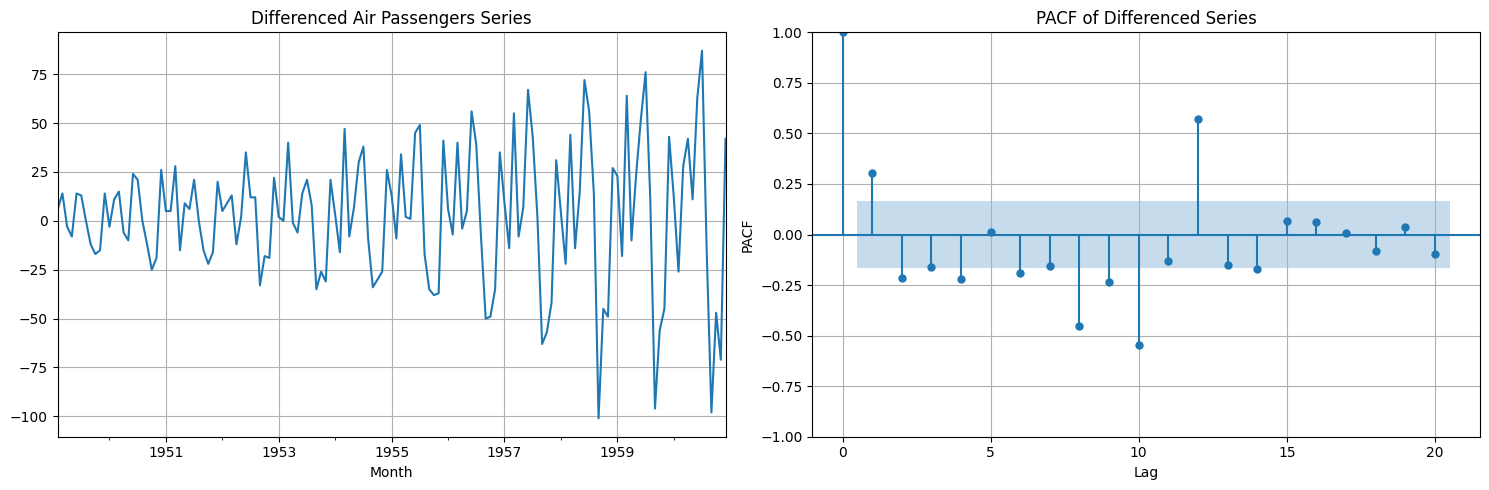

In [3]:
passengers_diff = df['Passengers'].diff().dropna()
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
passengers_diff.plot(ax=ax[0], title='Differenced Air Passengers Series')
ax[0].grid(True)
plot_pacf(passengers_diff, lags=20, ax=ax[1])
ax[1].set_title('PACF of Differenced Series')
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('PACF')
ax[1].grid(True)
plt.tight_layout()
plt.show()

In [4]:
p = 1
ar_model = ARIMA(df['Passengers'], order=(p, 1, 0))
ar_results = ar_model.fit()
print("--- AR Model Results ---")
print(f"Phi Value -> {list(ar_results.params)[0]}")

--- AR Model Results ---
Phi Value -> 0.3065504940412645


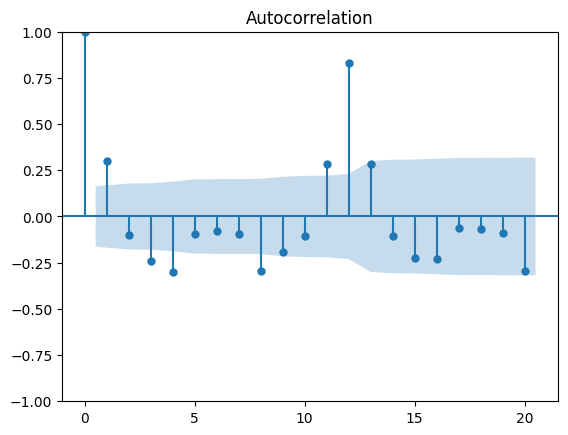

In [5]:
plot_acf(passengers_diff, lags=20)
plt.show()


--- MA Model Results ---
                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -695.547
Date:                Mon, 08 Sep 2025   AIC                           1397.093
Time:                        22:03:12   BIC                           1405.982
Sample:                    01-01-1949   HQIC                          1400.705
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3822      0.072      5.283      0.000       0.240       0.524
ma.L2         -0.2633      0.062     -4.256      0.000      -0.384      -0.142
sigma2       979.2956    1

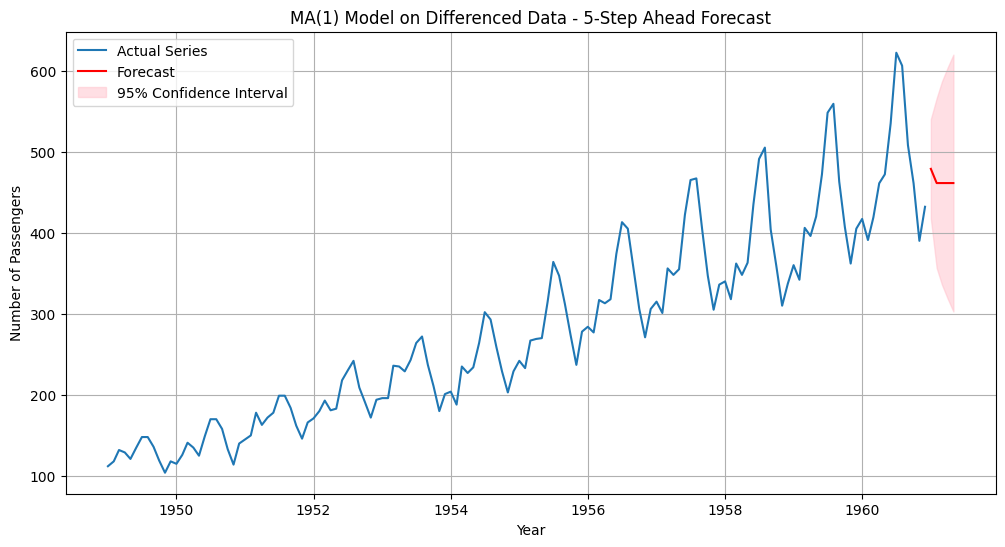

In [6]:
# Plot shows value spike at lag 1, so choosing lag 1
q = 2
ma_model = ARIMA(df['Passengers'], order=(0, 1, q))
ma_results = ma_model.fit()
print("\n--- MA Model Results ---")
print(ma_results.summary())

forecast = ma_results.get_forecast(steps=5)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(df['Passengers'], label='Actual Series')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.5, label='95% Confidence Interval')
plt.title('MA(1) Model on Differenced Data - 5-Step Ahead Forecast')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
print(forecast_mean)
print("------------")
print("------------")
print(forecast_ci)

1961-01-01    478.76397
1961-02-01    461.24823
1961-03-01    461.24823
1961-04-01    461.24823
1961-05-01    461.24823
Freq: MS, Name: predicted_mean, dtype: float64
------------
------------
            lower Passengers  upper Passengers
1961-01-01        417.429448        540.098493
1961-02-01        356.608692        565.887767
1961-03-01        336.109196        586.387264
1961-04-01        318.524290        603.972169
1961-05-01        302.880089        619.616370


In [8]:
ar_params_diff = ar_results.params
model_implied_mean_diff = ar_params_diff.get('const', 0) / (1 - ar_params_diff.get('ar.L1', 0))

actual_series_mean_diff = passengers_diff.mean()

print("\n--- Long-Run Mean Analysis (on Differenced Data) ---")
print(f"Model-Implied Long-Run Mean of Changes: {model_implied_mean_diff:.4f}")
print(f"Actual Average Change in Series: {actual_series_mean_diff:.4f}")
print(f"Difference: {abs(model_implied_mean_diff - actual_series_mean_diff):.4f}")


--- Long-Run Mean Analysis (on Differenced Data) ---
Model-Implied Long-Run Mean of Changes: 0.0000
Actual Average Change in Series: 2.2378
Difference: 2.2378
